# Build Forecasting Models

In this section we will create forecasting models using the clean data from above section. You can play around with the these variables in the cell below to configure the prediction settings.

- `Y_COLS`: The metric to forecast. Since smart 5 was determined to be a valueable indicator of failure, we'll use smart 5 as the default.
- `X_COLS`: Other features available. Some time series models can make use of other features too for generating a forecast. We will use smart 10, 187, 188, 197 and 198 as these additional features. These were determined to be useful from Google research, IBM research, backblaze, and the smart metrics wiki.
- `NDAYS_DATA`: How many days of data available in at runtime. Since the `diskprediction_local` module of ceph stores only 6 days of smart data, our models will only have that much data available.
- `NDAYS_TO_PREDICT`: How many days into the future to forecast. Since we have a short amount of historical data, we will be forecasting for a short period too.

In [6]:
# imports
import pdb
import datetime as dt
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

import statsmodels.api as sm

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

In [2]:
# set which columns are metadata and which ones are smart attribuetes
meta_cols = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure']

# set which columns to use in analysis
# NOTE: this determined based on backblaze research, ibm paper, and SMART wiki
smart_stats_to_keep = [
    5,
    10,
    187,
    188,
    197,
    198,
]
smart_cols = [f'smart_{i}_raw' for i in smart_stats_to_keep]
smart_cols += [f'smart_{i}_normalized' for i in smart_stats_to_keep]

In [3]:
# training setup config
Y_COLS = ['smart_5_normalized', 'smart_5_raw']
y_smart_stats = set([col.split('_')[1] for col in Y_COLS])

X_COLS = [c for c in smart_cols if c.split('_')[1] not in y_smart_stats]

# Y_COLS = smart_cols
# X_COLS = smart_cols

NDAYS_DATA = 6
NDAYS_TO_PREDICT = 6

In [4]:
# load preprocessed data
working_ts_df = pd.read_parquet(f'../../data/interim/working_ts_df_1612199672.650661.parquet')
failed_ts_df = pd.read_parquet(f'../../data/interim/failed_ts_df_1612199672.650661.parquet')

## 1d CNN

In [5]:
dummy_df = pd.DataFrame(data=np.random.rand(14, 3), columns=['a', 'b', 'c'])
dummy_df

,a,b,c
0,0.621308,0.899428,0.048923
1,0.668751,0.417322,0.077673
2,0.537994,0.074105,0.317877
3,0.670195,0.006522,0.846821
4,0.377231,0.904423,0.731788
5,0.812453,0.029192,0.115246
6,0.484441,0.343841,0.317835
7,0.875681,0.273678,0.135026
8,0.712221,0.077387,0.123365
9,0.670871,0.949737,0.478901


In [30]:
def create_training_set(df):
    X = np.empty(shape=(len(df) - NDAYS_DATA - NDAYS_TO_PREDICT + 1, NDAYS_DATA, len(df.columns)))
    y = np.empty(shape=(len(df) - NDAYS_DATA - NDAYS_TO_PREDICT + 1, NDAYS_TO_PREDICT, len(df.columns)))
    for i, end_idx in enumerate(range(NDAYS_DATA, len(df) - NDAYS_TO_PREDICT + 1)):
        start_idx = end_idx - NDAYS_DATA
        X[i, :] = df.iloc[start_idx: end_idx]
        y[i, :] = df.iloc[end_idx: end_idx + NDAYS_TO_PREDICT]
    return X, y
        
X, y = create_training_set(dummy_df)
X[-1], y[-1]

(array([[0.25125355, 0.73632069, 0.79641006],
        [0.75633884, 0.56983052, 0.02458231],
        [0.46915825, 0.09514835, 0.0641205 ],
        [0.92426979, 0.14470132, 0.41154911],
        [0.59838094, 0.43972263, 0.76888601],
        [0.82262437, 0.89536196, 0.75503281]]),
 array([[0.06244443, 0.30705773, 0.62383146],
        [0.74499551, 0.86180985, 0.87240191],
        [0.19606076, 0.62311761, 0.5378949 ],
        [0.93745725, 0.2704685 , 0.12013281],
        [0.56622065, 0.25103294, 0.46788787],
        [0.74895727, 0.97802938, 0.48257459]]))

In [ ]:
# cnn model
model = Sequential()
model.add(
    Conv1D(
        filters=64,
        kernel_size=2,
        activation='relu',
        input_shape=(n_steps, n_features),
    )
)
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

## VARMAX

## fixme: NDAYS_DATA-1 should be NDAYS_DATA

In [92]:
def get_varmax_mses(drive_ts):
#     drive_ts.index = pd.DatetimeIndex(drive_ts.index.values, freq='D')
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA, len(drive_ts)-1):
        
        # maybe normalize values before feeding to model?
        
        new_drive_ts = drive_ts[smart_cols].iloc[end_idx-NDAYS_DATA+1: end_idx+1+NDAYS_TO_PREDICT]
        
        if (new_drive_ts.std()==0).all():
            continue
        else:
            print('proceeding with calculation')
        
        import pdb; pdb.set_trace()
        
        new_drive_ts = ((new_drive_ts - new_drive_ts.mean()) / new_drive_ts.std()).fillna(0)
        
        # fit model
        model = sm.tsa.VARMAX(
            endog=new_drive_ts[X_COLS].iloc[:NDAYS_DATA],
            exog=new_drive_ts[Y_COLS].iloc[:NDAYS_DATA],
#             order=(NDAYS_DATA, NDAYS_DATA),
        )
        
        res = model.fit(maxiter=1000, disp=False)
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

In [93]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_varmax_mses)
baseline_mses
# # df to store all results
# all_mses = baseline_mses.to_frame('mse_baseline')

# # average mse across days
# print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')

proceeding with calculation
> <ipython-input-92-7397348e49e2>(18)get_varmax_mses()
     16         import pdb; pdb.set_trace()
     17 
---> 18         new_drive_ts = ((new_drive_ts - new_drive_ts.mean()) / new_drive_ts.std()).fillna(0)
     19 
     20         # fit model

ipdb> n
> <ipython-input-92-7397348e49e2>(21)get_varmax_mses()
     19 
     20         # fit model
---> 21         model = sm.tsa.VARMAX(
     22             endog=new_drive_ts[X_COLS].iloc[:NDAYS_DATA],
     23             exog=new_drive_ts[Y_COLS].iloc[:NDAYS_DATA],

ipdb> n
> <ipython-input-92-7397348e49e2>(22)get_varmax_mses()
     20         # fit model
     21         model = sm.tsa.VARMAX(
---> 22             endog=new_drive_ts[X_COLS].iloc[:NDAYS_DATA],
     23             exog=new_drive_ts[Y_COLS].iloc[:NDAYS_DATA],
     24 #             order=(NDAYS_DATA, NDAYS_DATA),

ipdb> n
> <ipython-input-92-7397348e49e2>(23)get_varmax_mses()
     21         model = sm.tsa.VARMAX(
     22             endog=new_drive_

/opt/app-root/src/.local/share/virtualenvs/ceph_drive_failure-6l7He7yy/lib64/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



> <ipython-input-92-7397348e49e2>(27)get_varmax_mses()
     25         )
     26 
---> 27         res = model.fit(maxiter=1000, disp=False)
     28 
     29         # predict and get mse

ipdb> n


/opt/app-root/src/.local/share/virtualenvs/ceph_drive_failure-6l7He7yy/lib64/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



numpy.linalg.LinAlgError: Matrix is not positive definite
> <ipython-input-92-7397348e49e2>(27)get_varmax_mses()
     25         )
     26 
---> 27         res = model.fit(maxiter=1000, disp=False)
     28 
     29         # predict and get mse

ipdb> n
--Return--
None
> <ipython-input-92-7397348e49e2>(27)get_varmax_mses()
     25         )
     26 
---> 27         res = model.fit(maxiter=1000, disp=False)
     28 
     29         # predict and get mse

ipdb> n
pandas._libs.reduction.InvalidApply: Let this error raise above us
> /opt/app-root/src/.local/share/virtualenvs/ceph_drive_failure-6l7He7yy/lib64/python3.6/site-packages/pandas/core/groupby/ops.py(965)fast_apply()
    963         # must return keys::list, values::list, mutated::bool
    964         starts, ends = lib.generate_slices(self.slabels, self.ngroups)
--> 965         return libreduction.apply_frame_axis0(sdata, f, names, starts, ends)
    966 
    967     def _chop(self, sdata: DataFrame, slice_obj: slice) -> DataFrame:

BdbQuit: 

## Baseline

In this section we will fit baseline models for the forecasting task. We will compare the performance of the ML models with this baseline to gauge how informative are the models. The baseline model here is one that predicts the next N days will be the same as today.

In [16]:
def get_baseline_mses_windowwise(drive_ts):
    """
    Predict the next N days the value will be same as today.
    Calculate MSE at the end of each training window
    """
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - drive_ts[Y_COLS[0]].iloc[end_idx])**2).mean()
        
    return mses

### Failed Drives

In [40]:
# calculate baseline
baseline_mses = failed_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses = baseline_mses.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n', baseline_mses.mean(level=0), end='\n\n')

Average MSE for each drive:

 serial_number
S300WFGR          NaN
S300Z4TZ     0.031410
S300Z7P1     0.000000
S301FDQW    10.322619
S301GMWQ     0.000000
              ...    
ZLW0G6CE     0.000000
ZLW0G6FJ          NaN
ZLW0GK7E     0.000000
ZLW0GKE4     0.000000
ZLW0GPC5          NaN
Length: 272, dtype: float64



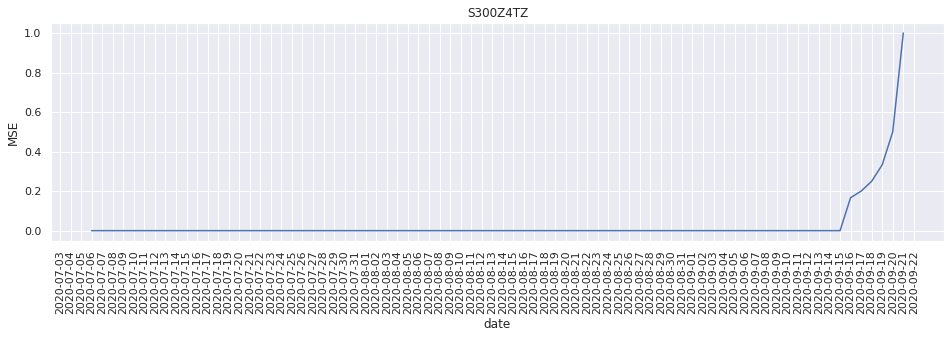

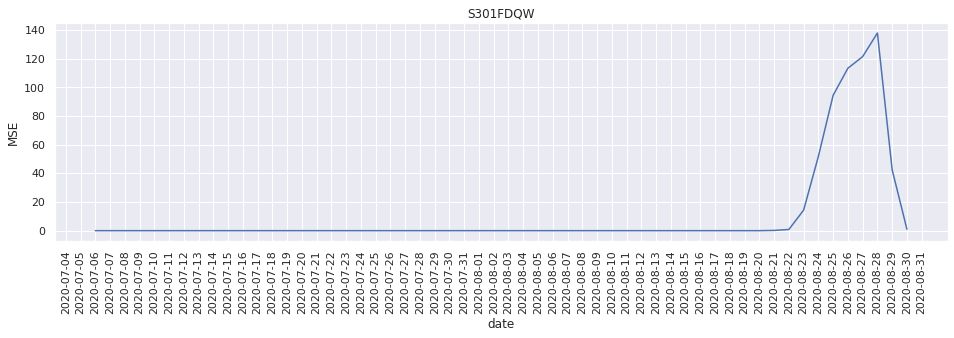

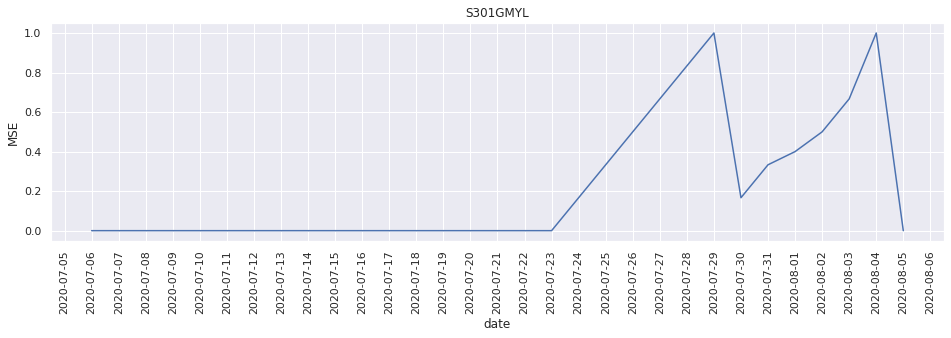

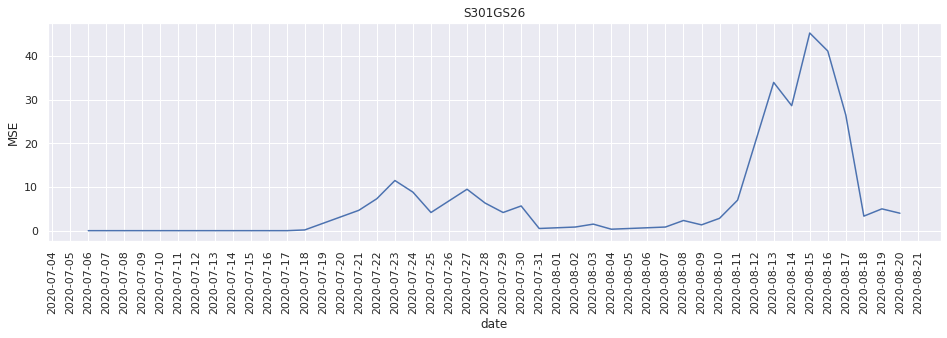

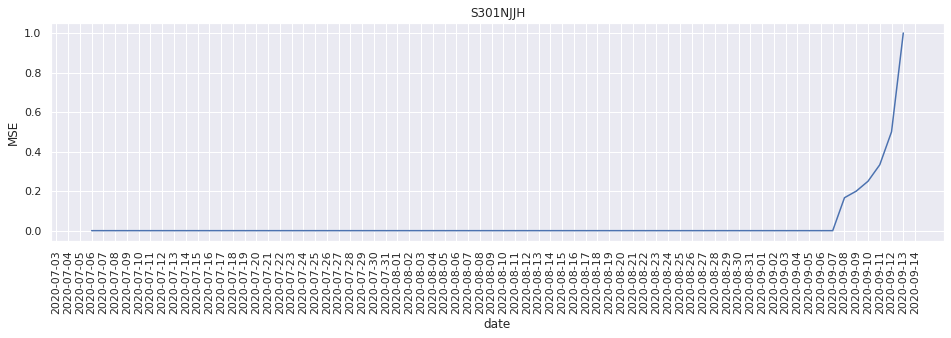

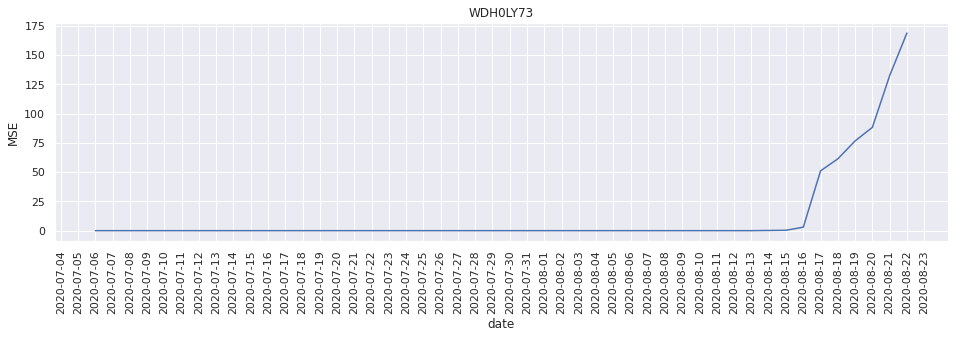

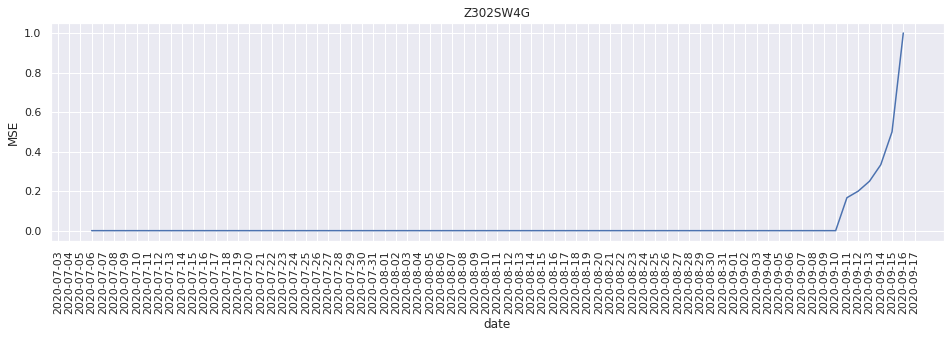

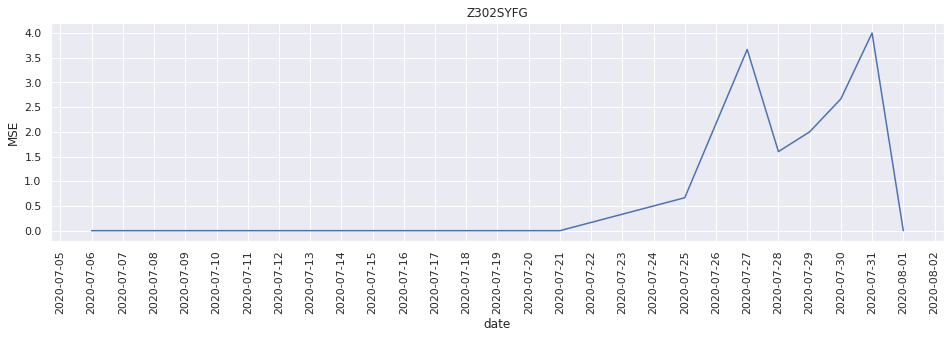

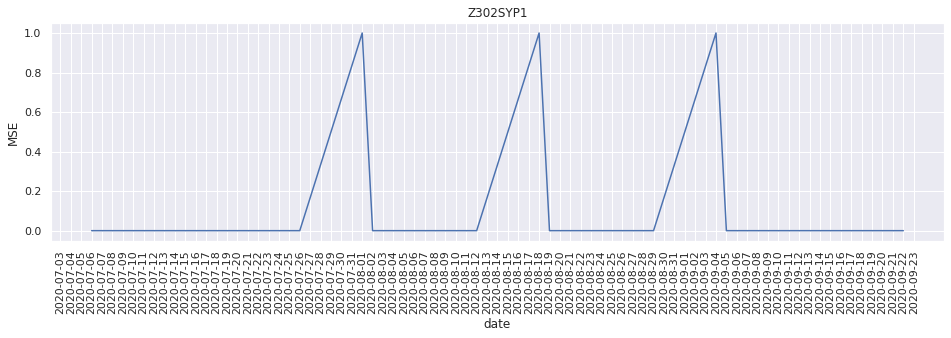

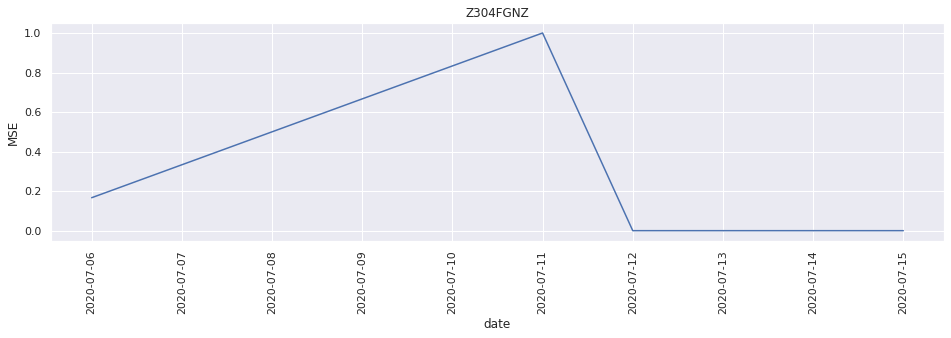

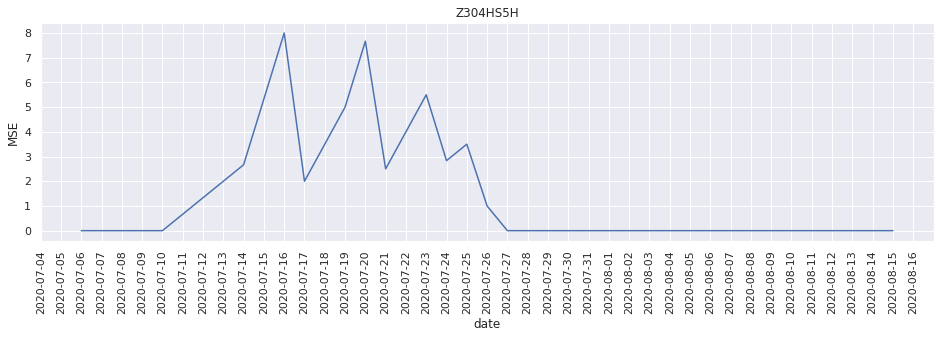

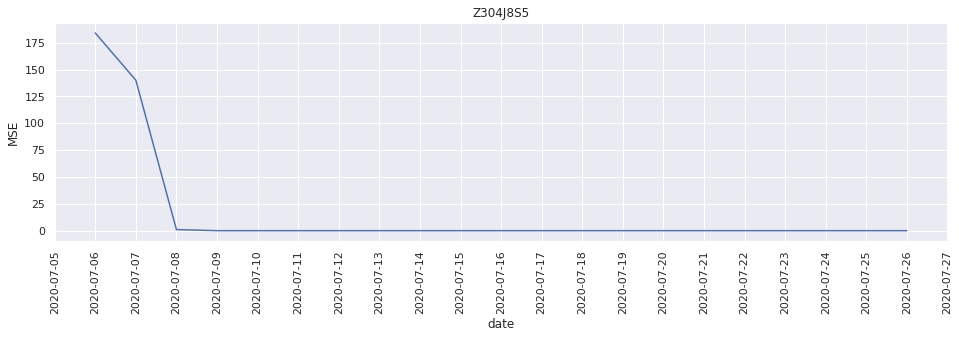

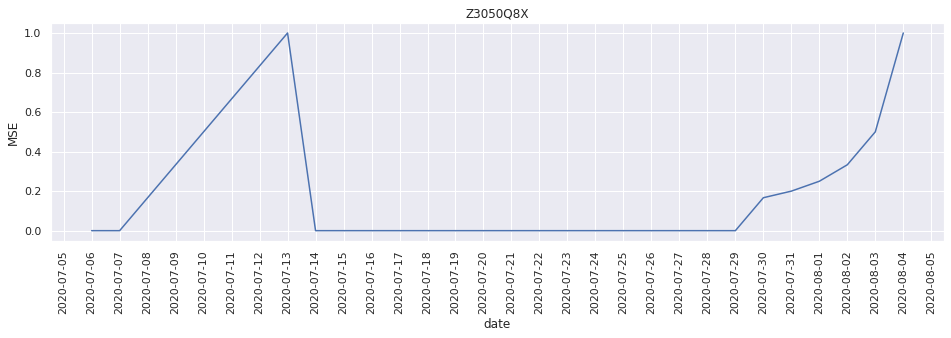

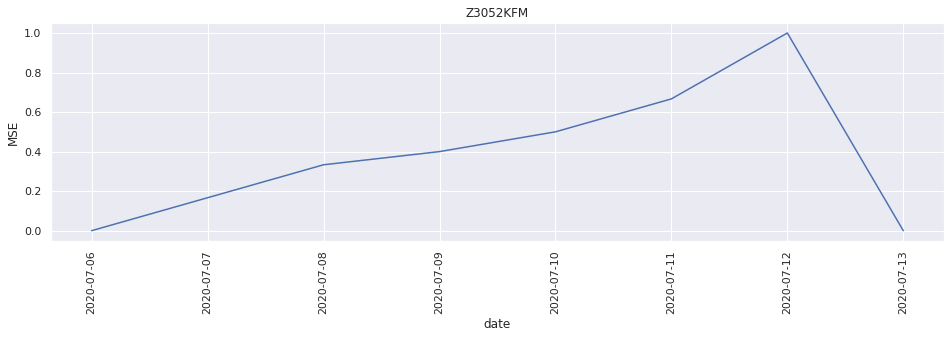

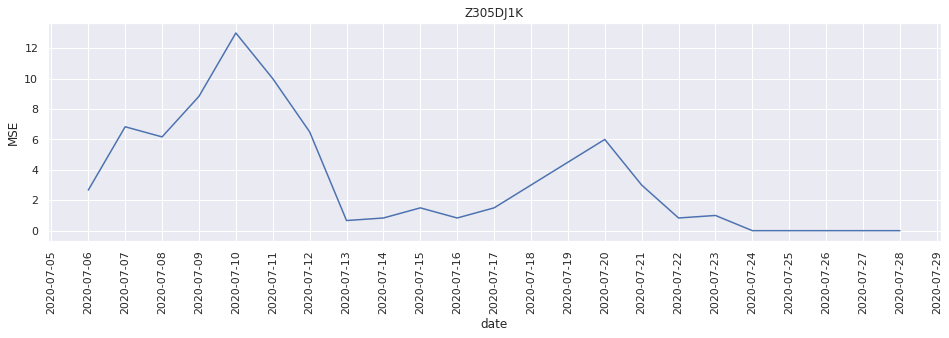

In [18]:
# visualize how mses change over time when using baseline strategy
i = 0
to_plot = 15
for ser in baseline_mses.index.get_level_values(0).unique():
    # get mse for each day/window
    ser_mses = baseline_mses.loc[ser]
    
    # dont plot if all nans
    if not ser_mses.isna().all():
    
        # dont plot if the metric to predict has had the same value till fail
        if failed_ts_df[failed_ts_df['serial_number']==ser][Y_COLS[0]].std():
            fig, ax = plt.subplots(figsize=(16, 4))
            sns.lineplot(
                ax=ax,
                x=ser_mses.index,
                y=ser_mses.values,
            )
            plt.title(ser)
            plt.ylabel('MSE')
            plt.xticks(rotation=90)
            plt.show()
            
            # dont plot everything
            i += 1
            if i==to_plot:
                break

### Results

From the above graphs, we can see that the baseline strategy works fine when the hard drive is healthy i.e. shows no symptoms of failure. However, as it approaches end of life the error in baseline model predictions rises significantly. So it might seem like a good strategy but it actually provides very little information when it is needed the most.

### Working Drives

In [19]:
# calculate baseline for healthy drives
baseline_mses_working = working_ts_df.groupby('serial_number').apply(get_baseline_mses_windowwise)

# df to store all results
all_mses_working = baseline_mses_working.to_frame('mse_baseline')

# average mse across days
print('Average MSE for each drive:\n\n')
display(baseline_mses_working.mean(level=0))

serial_number
S300VKRB    0.0
S300VLKS    0.0
S300WE24    0.0
S300WE6K    0.0
S300WEAV    0.0
           ... 
ZHZ656DW    0.0
ZHZ65C16    0.0
ZJV009E3    0.0
ZJV00AR3    0.0
ZR50121P    NaN
Length: 136, dtype: float64

In [20]:
# what is the WORST average mse using baseline strategy
baseline_mses_working.mean(level=0).max()

0.040697674418604654

### Results

From the above results, it seems that baseline model works extremely well for healthy drives (MSE=0 for most hard drives). The graphs in the section above also indicated the same thing - there is barely any unexpected change in these SMART metrics when the drive is healthy. Therefore in the following sections we will evaluate models only on failed data, since any model would likely be decently performant (if not perfect) for healthy drives. 

## Linear Regression

In [21]:
# calculate windowwise mse for ols model for each drive
def get_linreg_mses_windowwise(drive_ts):
    # define model
    model = LinearRegression(
        normalize=True,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_linreg_mses_windowwise)

In [22]:
# update all results df and compare
all_mses['mse_linreg'] = windowwise_mses

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_linreg']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_linreg']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

,mse_baseline,mse_linreg
serial_number,,
ZCH0EA28,381.806250,148.840343
ZCH0CCSY,736.158333,612.876751
ZJV5M9KA,460.544444,378.915628
ZCH074SE,169.000000,157.084444
ZA1819E9,11.441667,4.145687
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


In [23]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg
date,,
2020-07-01,NaN,NaN
2020-07-02,NaN,NaN
2020-07-03,NaN,NaN
2020-07-04,NaN,NaN
2020-07-05,NaN,NaN
2020-07-06,958.666667,57.512789
2020-07-07,973.333333,59.737506
2020-07-08,479.833333,227.104444
2020-07-09,122.200000,473.360000


## Lasso

In [ ]:
# calculate windowwise mse for lasso model for each drive
def get_lasso_mses_windowwise(drive_ts):
    # define model
    model = Lasso(
        normalize=True,
        random_state=42,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_lasso_mses_windowwise)

In [25]:
# update all results df and compare
all_mses['mse_lasso'] = windowwise_mses

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_lasso']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_lasso']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

,mse_baseline,mse_lasso
serial_number,,
ZCH0EA28,381.806250,89.382469
ZJV5M9KA,460.544444,417.703068
ZCH0CCSY,736.158333,707.688888
S300Z4TZ,0.031410,0.031410
ZCH083F6,0.000000,0.000000
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


In [26]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso
date,,,
2020-07-01,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283
2020-07-07,973.333333,59.737506,82.382696
2020-07-08,479.833333,227.104444,64.721416
2020-07-09,122.200000,473.360000,188.592501


## Bayesian Ridge Regression

In [27]:
# calculate windowwise mse for br model for each drive
def get_br_mses_windowwise(drive_ts):
    # define model
    model = BayesianRidge(
        normalize=True,
    )

    # create dummy exogenous variable (train)
    dummy_xtrain = np.arange(start=0, stop=NDAYS_DATA).reshape(-1, 1)
    
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        
        # create dummy exogenous variable (test)
        dummy_xtest = np.arange(
            start=NDAYS_DATA, 
            stop=NDAYS_DATA + min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
        ).reshape(-1, 1)

        # fit model
        model.fit(
            X=dummy_xtrain,
            y=drive_ts[Y_COLS[0]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
        )
        
        # predict and get mse
        preds = model.predict(dummy_xtest).flatten()
        
        if np.isnan(preds).any():
            pdb.set_trace()
            
        mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_br_mses_windowwise)

In [28]:
# update all results df and compare
all_mses['mse_br'] = windowwise_mses

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_br']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_br']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

,mse_baseline,mse_br
serial_number,,
ZCH0EA28,381.806250,142.547238
ZCH0CCSY,736.158333,635.306334
ZJV5M9KA,460.544444,400.676324
ZA1819E9,11.441667,4.100040
ZCH074SE,169.000000,162.721665
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


In [29]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br
date,,,,
2020-07-01,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898
2020-07-07,973.333333,59.737506,82.382696,57.570863
2020-07-08,479.833333,227.104444,64.721416,219.038516
2020-07-09,122.200000,473.360000,188.592501,457.571010


## ARIMA

In [ ]:
# calculate windowwise mse for arima model for each drive
def get_arima_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)
    
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        try:
            # init model and train
            model = ARIMA(
                endog=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
                order=(1, 1, 0),
                freq='D',
            )
            model = model.fit()
            
            # forecast and calculate error
            preds = model.forecast(steps=NDAYS_TO_PREDICT)
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()

        # value errors occur when dates are not continuous
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
            
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_arima_mses_windowwise)

In [31]:
# update all results df and compare
all_mses['mse_arima'] = windowwise_mses

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_arima']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_arima']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

,mse_baseline,mse_arima
serial_number,,
ZCH0EA28,381.806250,267.692262
ZCH0CCSY,736.158333,661.323586
ZCH074SE,169.000000,145.534586
ZA12RB44,4.000000,0.133154
ZA16DDTZ,9.000000,5.670446
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


In [32]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br,mse_arima
date,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898,628.750569
2020-07-07,973.333333,59.737506,82.382696,57.570863,524.365544
2020-07-08,479.833333,227.104444,64.721416,219.038516,48.255805
2020-07-09,122.200000,473.360000,188.592501,457.571010,530.488499


## SARIMAX

In [ ]:
# calculate windowwise mse for sarimax model for each drive
def get_sarimax_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)

    for end_idx in range(NDAYS_DATA-1, len(drive_ts)):
        try:
            model = SARIMAX(
                endog=drive_ts[[Y_COLS[0]]].iloc[end_idx+1-NDAYS_DATA: end_idx+1],
                order=(1, 1, 0),
                freq='D',
            )
            model = model.fit()
            preds = model.forecast(steps=NDAYS_TO_PREDICT)
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT] - preds)**2).mean()
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_sarimax_mses_windowwise)

In [34]:
# update all results df and compare
all_mses['mse_sarimax'] = windowwise_mses

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_sarimax']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_sarimax']-mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

,mse_baseline,mse_sarimax
serial_number,,
ZCH0EA28,381.806250,267.692262
ZCH0CCSY,736.158333,661.323586
ZCH074SE,169.000000,145.534586
ZA12RB44,4.000000,0.133154
ZA16DDTZ,9.000000,5.670446
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


In [35]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br,mse_arima,mse_sarimax
date,,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898,628.750569,628.750569
2020-07-07,973.333333,59.737506,82.382696,57.570863,524.365544,524.365544
2020-07-08,479.833333,227.104444,64.721416,219.038516,48.255805,48.255805
2020-07-09,122.200000,473.360000,188.592501,457.571010,530.488499,530.488499


## Prophet

In [36]:
# calculate windowwise mse for sarimax model for each drive
def get_prophet_mses_windowwise(drive_ts):
    mses = pd.Series(index=drive_ts.index)
    for end_idx in range(NDAYS_DATA-1, len(drive_ts)-1):
        try:
            # init prophet model
            model = Prophet(
                n_changepoints=3,
                daily_seasonality=True,
                weekly_seasonality=False,
                yearly_seasonality=False,
                uncertainty_samples=False,
            )

            # fit to historical data (today to today minus NDAYS_TO_PREDICT)
            model.fit(

                drive_ts[Y_COLS].iloc[end_idx+1-NDAYS_DATA: end_idx+1]\
                        .reset_index()\
                        .rename(columns={'date': 'ds', f'{Y_COLS[0]}': 'y'})

            )

            # predict future
            preds = model.predict(
                model.make_future_dataframe(
                    periods=min(NDAYS_TO_PREDICT, len(drive_ts)-end_idx-1),
                    include_history=False,
                )
            )['yhat'].values

            # calculate mean squared error at this date
            mses.iloc[end_idx] = ((drive_ts[Y_COLS[0]].iloc[end_idx+1: end_idx+1+NDAYS_TO_PREDICT].values - preds)**2).mean()
        except ValueError as ve:
            mses.iloc[end_idx] = np.nan
    return mses

windowwise_mses = failed_ts_df.groupby('serial_number').apply(get_prophet_mses_windowwise)

In [37]:
# save so that computation doesnt have to be run again
import datetime as dt
pd.DataFrame(windowwise_mses.to_frame('mse').to_records()).to_parquet(
    f"prophet_mses_{dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.parquet",
)

# # read from saved so that computation doesnt have to be run again
# windowwise_mses = pd.read_parquet('prophet_mses.parquet').set_index(['serial_number', 'date'])['mse']
# windowwise_mses

In [38]:
# update all results df and compare
all_mses['mse_prophet'] = windowwise_mses

# average mse across days
mean_mses = all_mses[['mse_baseline', 'mse_prophet']].groupby('serial_number').mean()

# improvement over baseline
diff = mean_mses['mse_prophet'] - mean_mses['mse_baseline']
mean_mses = mean_mses.reindex(diff.sort_values().index)
print('Avg. MSE for each drive:')
display(mean_mses)

# average overall improvement over baseline
print('Avg. Improvement =', -diff.mean())

,mse_baseline,mse_prophet
serial_number,,
ZCH0EA28,381.806250,148.774488
ZCH0CCSY,736.158333,591.042024
ZJV5M9KA,460.544444,376.511968
ZA180YNM,62.883333,50.712123
ZCH074SE,169.000000,157.133496
...,...,...
ZHZ50G0W,NaN,NaN
ZHZ5W6L4,NaN,NaN
ZL005C4H,NaN,NaN


In [39]:
# peek at drive with most improvement
all_mses.loc[mean_mses.iloc[0].name]

,mse_baseline,mse_linreg,mse_lasso,mse_br,mse_arima,mse_sarimax,mse_prophet
date,,,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-06,958.666667,57.512789,209.017283,66.331898,628.750569,628.750569,57.550052
2020-07-07,973.333333,59.737506,82.382696,57.570863,524.365544,524.365544,59.718423
2020-07-08,479.833333,227.104444,64.721416,219.038516,48.255805,48.255805,226.997537
2020-07-09,122.200000,473.360000,188.592501,457.571010,530.488499,530.488499,473.553431


# Conclusion

From the above experiments it seems like the Prophet model outperforms the rest. However, a simple OLS model works quite well too with its average MSE not too far away from that of Prophet. Nonetheless, Prophet has the advantage of providing confidence intervals, and also account for weekly/daily/yearly seasonality. Therefore it is likely that when the amount of available historical data at runtime is increased, Prophet would perform even better than OLS.